In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
BSIZE_SP = 512
MDATA_LIST = [b'title', b'date', b'plotname', b'flags',
              b'no. variables', b'no. points', b'dimensions',
              b'command', b'option']

class NGSpiceRaw:
    def __init__(self, fname: str, live: bool = True):
        self.fname = fname
        self.live = live

        self._reload()

    def _reload(self):
        self.arrs, self.plots = self._read_raw(self.fname)
        self.plot, self.arr = self.plots[-1], self.arrs[-1]
        print(f"Loaded {len(self.plots)} plots from {self.fname}")

    def _read_raw(self, fname: str):
        """
        Read a binary ngspice .raw file.

        Returns:
          arrs  : list of numpy structured arrays, one per plot
          plots : list of metadata dicts, parallel to arrs
        """
        with open(fname, 'rb') as fp:
            arrs = []
            plots = []
            plot = {}
            while True:
                line = fp.readline(BSIZE_SP)
                if not line:
                    break
                parts = line.split(b':', 1)
                if len(parts) != 2:
                    continue
                key, val = parts[0].lower(), parts[1].strip()
                if key in MDATA_LIST:
                    plot[key] = val
                if key == b'variables':
                    nvars   = int(plot[b'no. variables'])
                    npoints = int(plot[b'no. points'])
                    plot['varnames'] = []
                    plot['varunits'] = []
                    for _ in range(nvars):
                        ascii_line = fp.readline(BSIZE_SP).decode('ascii')
                        idx, name, *unit = ascii_line.split()
                        plot['varnames'].append(name)
                        plot['varunits'].append(unit[0])
                if key == b'binary':
                    # build dtype (complex if flagged, else float)
                    fmt = np.complex_ if b'complex' in plot[b'flags'] else float
                    row_dtype = np.dtype({
                        'names':   plot['varnames'],
                        'formats': [fmt]*len(plot['varnames'])
                    })
                    # read data block
                    data = np.fromfile(fp, dtype=row_dtype, count=npoints)
                    arrs.append(data)
                    plots.append(plot.copy())
                    plot.clear()
                    fp.readline()

        return arrs, plots
    
    def select(self, idx: int):
        """
        Select a plot by index.
        """
        if idx < -len(self.plots) or idx >= len(self.plots):
            raise IndexError("Index out of range")
        
        self.plot = self.plots[idx]
        self.arr = self.arrs[idx]

        return self.plot, self.arr
    
    @property
    def names(self):
        return self.arr.dtype.names
    
    def __getitem__(self, key):
        """
        Get a variable by name or index.
        """
        if self.live:
            self._reload()

        if isinstance(key, int):
            return self.arr[key]
        elif isinstance(key, str):
            if key in self.names:
                return self.arr[key]
            else:
                raise KeyError(f"Variable '{key}' not found")
        else:
            raise TypeError("Key must be an int or str")

In [4]:
raw = NGSpiceRaw('../simulation/inv_tb.raw')

Loaded 1 plots from ../simulation/inv_tb.raw


In [5]:
print("Fields:", raw.names)

Fields: ('time', 'v(clk)', 'v(in)', 'v(out_n)', 'v(out)', 'i(vtest)', 'i(vclock)')


In [6]:
from typing import Optional
%matplotlib widget

def plot_digital_signals(raw: NGSpiceRaw, signals: list[str], time_range: Optional[tuple[float, float]] = None, spacing: float = 1.25):

    time = raw['time']

    plt.figure(figsize=(16, 2 + len(signals)))
    plt.title(raw.plot[b'title'].decode('ascii'))

    added_signals = []
    for i, signal in enumerate(signals):
        signal_name = f"v({signal.lower()})" if '(' not in signal else signal.lower()
        if signal_name not in raw.names:
            print(f"Signal '{signal_name}' not found in raw data")
            continue

        signal = raw[signal_name]

        plt.axhline(-i * spacing, color='black', lw=1.0, ls='--')
        plt.axhline(-i * spacing + 0.5, color='black', lw=0.75, ls='--')
        plt.axhline(-i * spacing + 1.0, color='black', lw=1.0, ls='--')
        # Gray background for each signal
        plt.fill_between(time, -i * spacing, -i * spacing + 1.0, color='lightgray', alpha=0.5)

        if signal.max() != signal.min():
            signal = (signal - signal.min()) / (signal.max() - signal.min())
        elif signal.max() == 0:
            signal = np.zeros_like(signal)
        else:
            signal = np.ones_like(signal)

        plt.plot(time, signal - i * spacing)
        added_signals.append(signal_name)

    # Replace y label ticks with signal names
    plt.xlabel('Time [s]')
    labels = plt.yticks([-i * spacing for i in range(len(added_signals))], added_signals)
    for i, label in enumerate(labels[1]):
        label.set_horizontalalignment('right')
        label.set_verticalalignment('bottom')
        label.set_color(f"C{i}")

    if time_range is not None:
        plt.xlim(time_range)
    else:
        plt.xlim(time[0], time[-1])

    plt.grid(axis='x', which='both', lw=0.75, ls='--', color='black')
    plt.show()

Loaded 1 plots from ../simulation/inv_tb.raw
Loaded 1 plots from ../simulation/inv_tb.raw
Loaded 1 plots from ../simulation/inv_tb.raw
Loaded 1 plots from ../simulation/inv_tb.raw


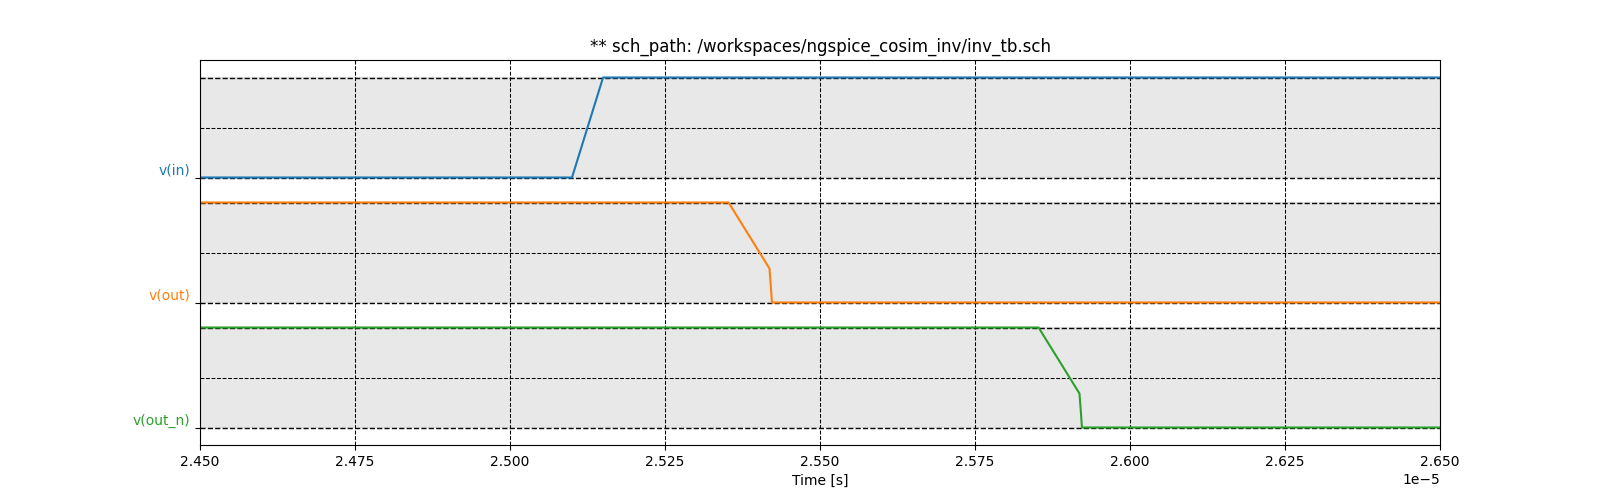

In [12]:
plot_digital_signals(
    raw,
    ['in', 'out', 'out_n'],
    time_range=(2.45e-5, 2.65e-5)
)